# Bridging the gap: model mixing with Gaussian processes

## Alexandra Semposki

### Date: 29 October 2021

## GPs with scikit learn

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mixing import Mixing, Switching, Models
from discrepancy import Discrepancy
from gaussprocess import GP

matplotlib.rcParams.update({
   'font.family': 'serif',
   'text.usetex': True,
})

Welcome to the BMM sandbox! Here you get to play!
Select a dpi for the figure.100

y-limits (enter "auto" if unknown): auto


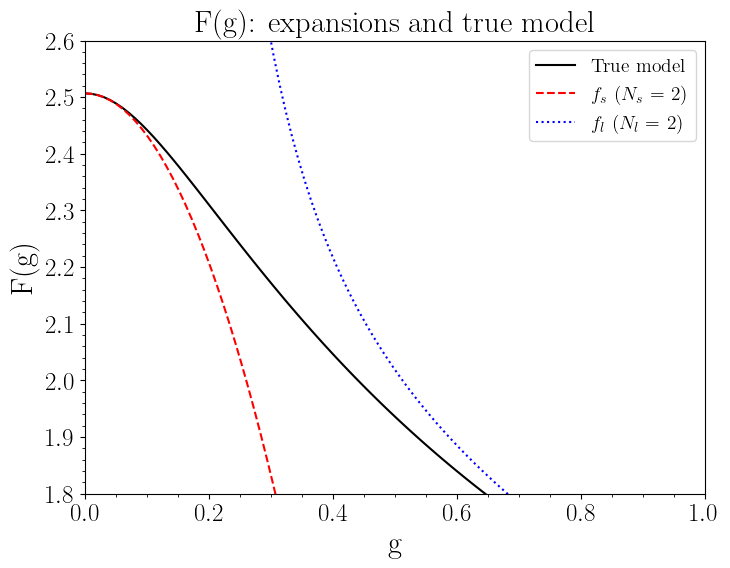

Would you like to save this figure? (yes/no)no


In [2]:
# first we need to see which models we want to mix
models = Mixing()
g = np.linspace(1e-6, 1.0, 100)
low = np.array([2])
high = np.array([2])
models.plot_models(g, low, high)

In [3]:
# begin by calling the GP class just to see if it works
new = GP(g, kernel="RBF", fix_length=False)

Initializing standard Constant * RBF kernel.


After loading the GP we wish to get some data from the models and try to emulate between the two. Let's take some data and plot it.

Which error model do you want to use? (uninformative/informative)informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]
[0.0656575 0.1565665 0.7727275 0.8434345]
Optimized parameters: 2.74**2, RBF(length_scale=1.06)
Set a dpi for the figure.100


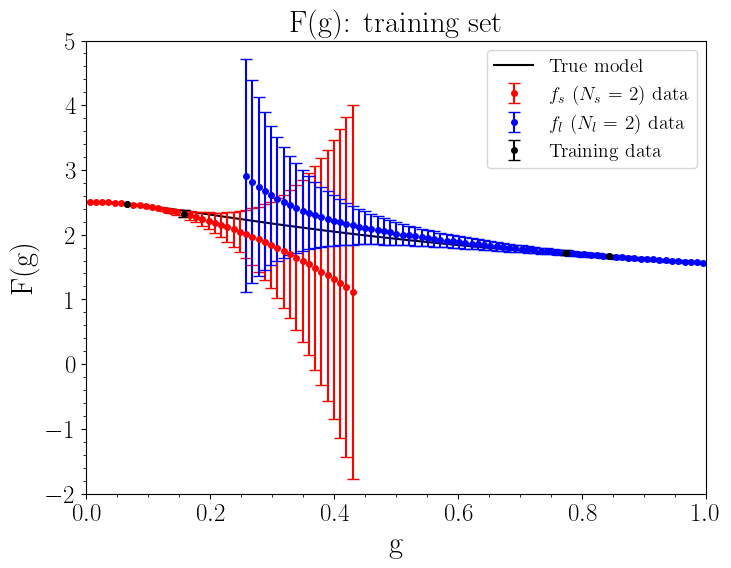

Would you like to save this figure? (yes/no)no
Which error model do you want to use? (uninformative/informative)informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]


In [4]:
trained = new.training(low, high, error=True)
gs, datas, sigmas = new.training_set(low, high)

In [5]:
# Now we use the training results to predict across the gap with new points. 


Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]
Set a dpi for the figure.100


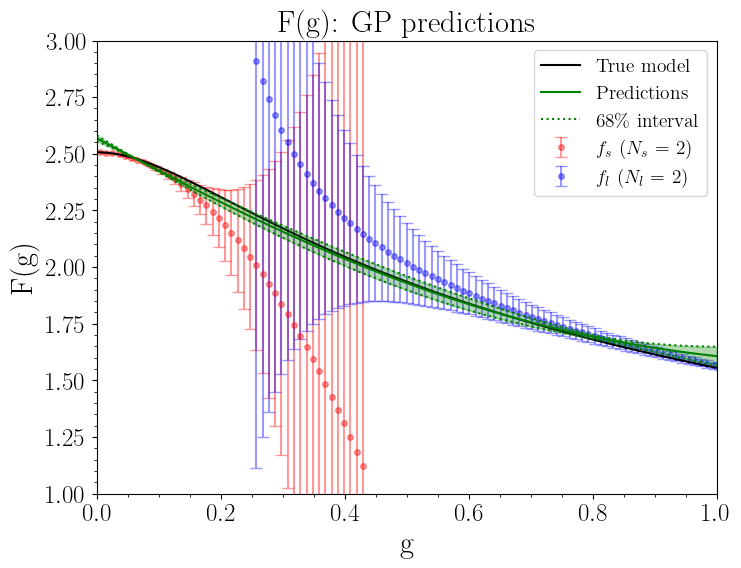

Would you like to save this figure? (yes/no)no


In [6]:
mean, sig, cov = new.validate(trained, low, high, interval=68)
#print(np.diag(cov))
#print(sig) #definitely the STANDARD DEVIATION!

11
80
0.11111199999999999 0.8080809999999999
(69, 69)
(23,)


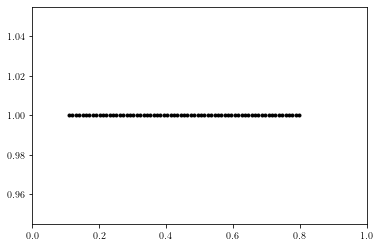

In [7]:
md_g, md_mean, md_sig, md_cov = new.MD_set(sigmas)

#try to add small variance to cov to make it less singular
md_cov = md_cov + 0.001*np.eye(len(md_cov))

#thin the prediction set to every 10 entries to try ref dist
md_gthin = md_g[::3]
md_meanthin = md_mean[::3]
md_sigthin = md_sig[::3]
md_covthin = md_cov[::3,::3]

print(np.shape(md_gthin))

In [8]:
#access and print the values of the std dev for testing and for the model predictions
# stdev_models = np.concatenate((new.stdev_low, new.stdev_high))
# print('   GP error  | Expansion error')
# for i in range(len(stdev_models)):
#     print('  {:.8f} |   {:.8f}'.format(sig[i], stdev_models[i]))

(100, 100) (5,) [[1.61752696e-04 1.34890457e-04 1.08770077e-04 ... 1.67396469e-04
  1.76573037e-04 1.85512658e-04]
 [1.34890457e-04 1.12513166e-04 9.07485611e-05 ... 1.42785303e-04
  1.50696893e-04 1.58416362e-04]
 [1.08770077e-04 9.07485611e-05 7.32161419e-05 ... 1.17719238e-04
  1.24309566e-04 1.30749520e-04]
 ...
 [1.67396469e-04 1.42785303e-04 1.17719238e-04 ... 1.32159884e-03
  1.41831876e-03 1.51704783e-03]
 [1.76573037e-04 1.50696893e-04 1.24309566e-04 ... 1.41831876e-03
  1.52271887e-03 1.62931017e-03]
 [1.85512658e-04 1.58416362e-04 1.30749520e-04 ... 1.51704783e-03
  1.62931017e-03 1.74395225e-03]]
(5, 5) [[ 1.61752696e-04 -2.32714069e-04 -3.40958084e-04 -2.31684431e-04
  -1.46280882e-05]
 [-2.32714069e-04  3.57938124e-04  5.63146869e-04  4.18453964e-04
   3.38025142e-05]
 [-3.40958084e-04  5.63146869e-04  9.57687001e-04  7.76351590e-04
   7.95165463e-05]
 [-2.31684431e-04  4.18453964e-04  7.76351590e-04  6.89484463e-04
   9.81950366e-05]
 [-1.46280882e-05  3.38025142e-05  7.

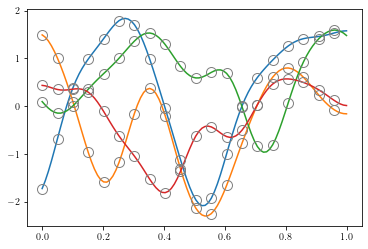

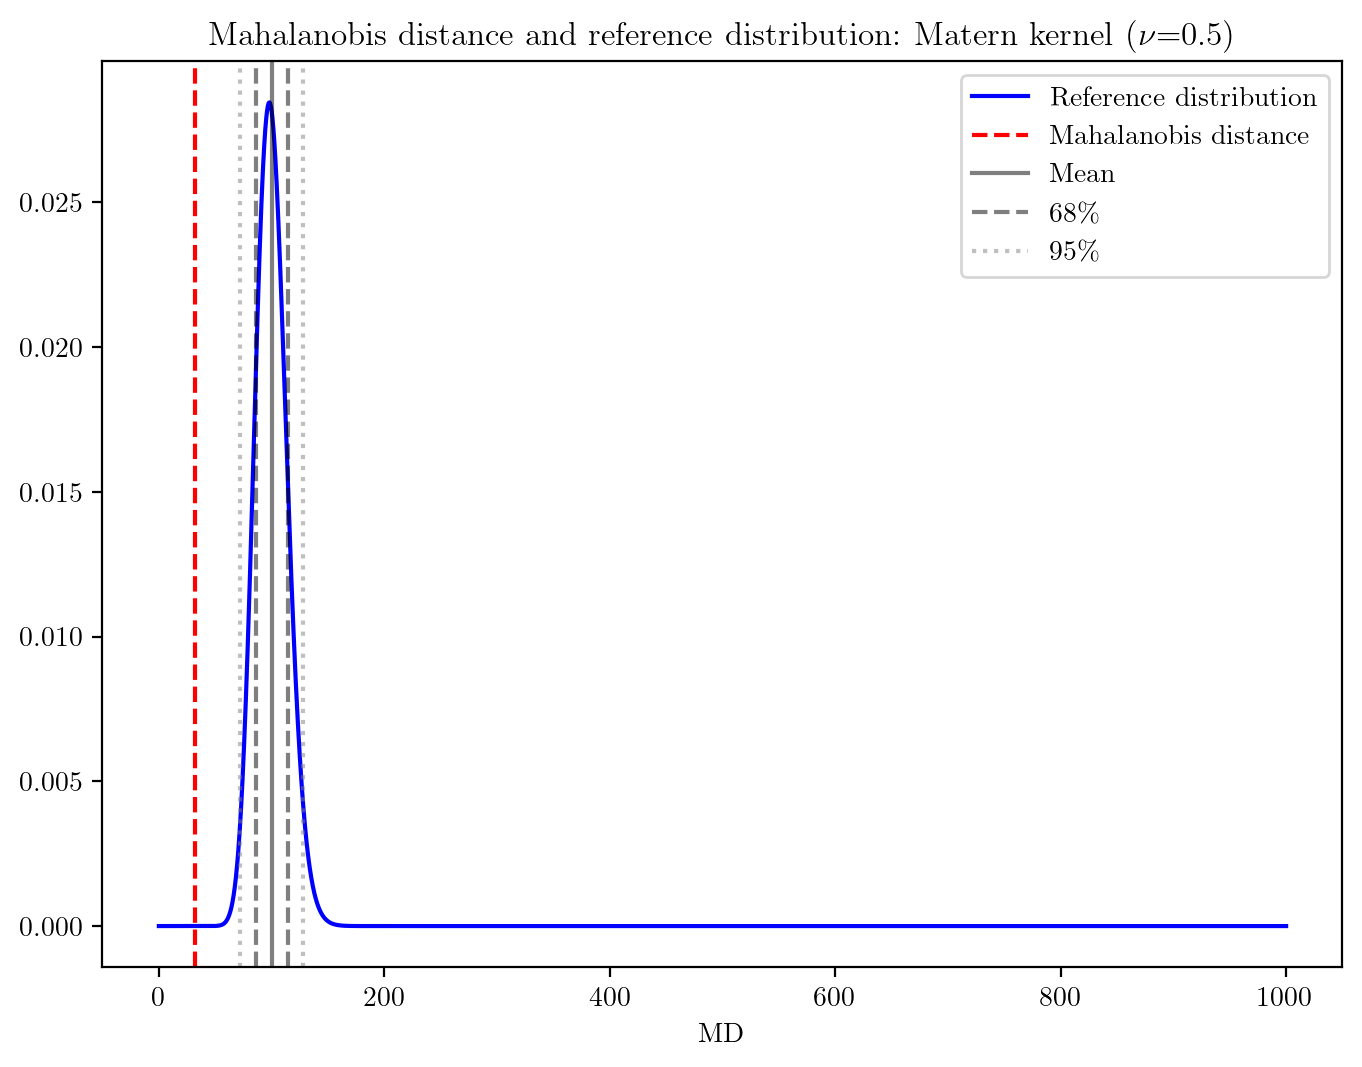

In [9]:
#find true values at the prediction points
fval = new.true_model(new.gpred)
distance = new.MD(fval, mean, cov)
print('Mahalanobis distance: {}'.format(distance))

#linspace for MD
mdspace = np.linspace(0.0, 1000.0, 10000)

#mean and stdev of distribution
df = len(new.gpred)
mu = stats.chi2.mean(df)
sigma = stats.chi2.std(df)
print(mu)

#plot the reference chi-squared distribution
plt.figure(figsize=(8,6),dpi=200)
plt.plot(mdspace, stats.chi2.pdf(mdspace, df), color='blue', label='Reference distribution')
plt.axvline(x=distance, color='red', linestyle='dashed', label='Mahalanobis distance')
plt.axvline(x=mu, color='black', alpha=0.5, label='Mean')
plt.axvline(x=mu+sigma, color='black', linestyle='dashed', alpha=0.5, label=r'68\%')
plt.axvline(x=mu-sigma, color='black', linestyle='dashed', alpha=0.5)
plt.axvline(x=mu+1.96*sigma, color='gray', linestyle='dotted', alpha=0.5, label=r'95\%')
plt.axvline(x=mu-1.96*sigma, color='gray', linestyle='dotted', alpha=0.5)
plt.xlabel('MD')
plt.title(r'Mahalanobis distance and reference distribution: Matern kernel ($\nu$=0.5)')
plt.legend()

In [10]:
#call the Discrepancy plotting function for 3 models
newplot = Discrepancy()
print(mean)
print(np.shape(mean))
print(mean.reshape(-1,1).T)

[2.56858354 2.55400169 2.53943591 2.52489005 2.51036791 2.49587326
 2.48140984 2.46698135 2.45259146 2.43824379 2.42394193 2.40968941
 2.39548974 2.38134636 2.36726269 2.35324208 2.33928784 2.32540323
 2.31159144 2.29785563 2.2841989  2.27062428 2.25713475 2.24373325
 2.23042263 2.2172057  2.20408521 2.19106383 2.17814418 2.16532881
 2.15262022 2.14002083 2.127533   2.11515902 2.1029011  2.09076142
 2.07874206 2.06684503 2.05507228 2.04342571 2.03190712 2.02051824
 2.00926076 1.99813628 1.98714631 1.97629233 1.96557573 1.95499782
 1.94455986 1.93426301 1.9241084  1.91409706 1.90422996 1.89450801
 1.88493202 1.87550278 1.86622097 1.85708722 1.84810209 1.83926608
 1.83057962 1.82204307 1.81365672 1.80542082 1.79733553 1.78940097
 1.78161719 1.77398416 1.76650182 1.75917004 1.75198862 1.74495733
 1.73807585 1.73134383 1.72476086 1.71832646 1.71204013 1.7059013
 1.69990934 1.69406359 1.68836334 1.68280782 1.67739623 1.67212772
 1.66700139 1.66201632 1.65717151 1.65246597 1.64789864 1.64346

Set a dpi for the figure.100

x-limits (enter "auto" if unknown): 0.,1.

y-limits (enter "auto" if unknown): 1.,3.
Which error model do you want to use, uninformative or informative?informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]
Which interval do you want to use: 68 or 95?68
(1, 100)


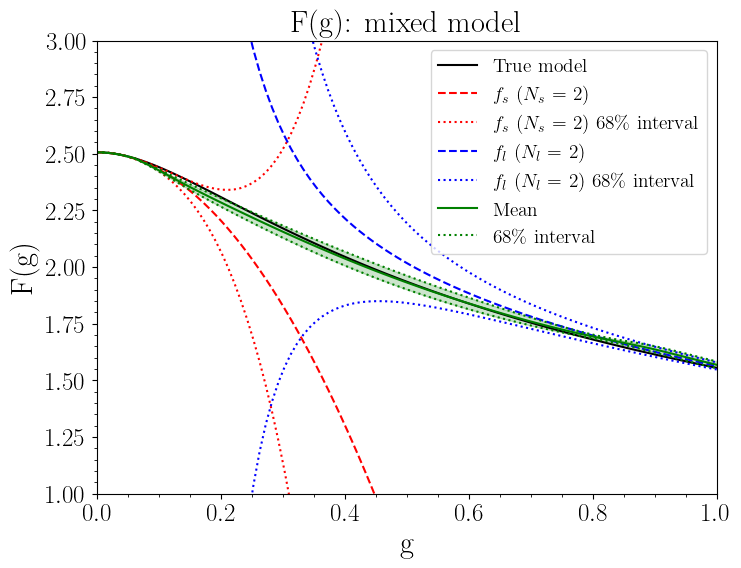

Would you like to save this figure? (yes/no)no


In [11]:
g_plot = np.linspace(1e-6, 1.0, 100)
newplot.plot_mix(g_plot, low, high, plot_fdagger=True, GP_mean=mean, GP_var=np.square(sig))

Set a dpi for the figure.100

x-limits (enter "auto" if unknown): 0.,1.

y-limits (enter "auto" if unknown): 1.,3.
Log scale? (yes/no)no
Which error model do you want to use, uninformative or informative?informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]
Which interval do you want to use: 68 or 95?68
(1, 100)
Which error model do you want to use, uninformative or informative?informative

Small-g expansion: error will be on the order of g^4.
[ 0.         0.        -0.4699928  0.       ]
Large-g expansion: error will be of the order g^3.
[ 1.81280495 -1.08599728  0.90640248]
Which interval do you want to use: 68 or 95?68
(1, 100)


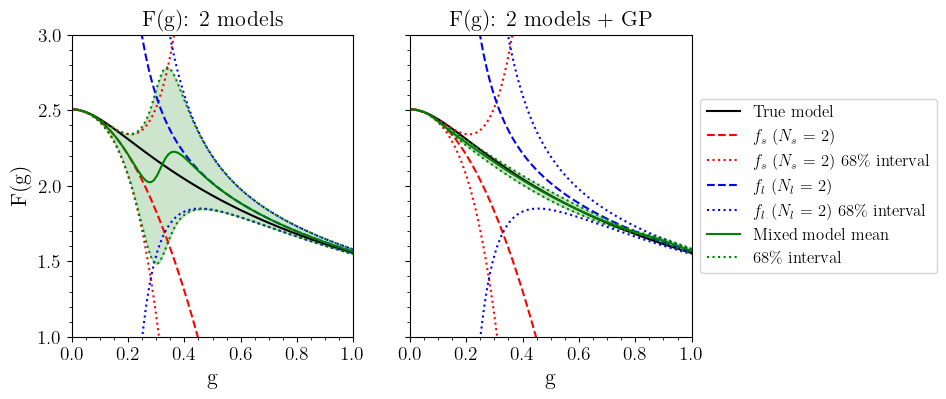

Would you like to save this figure? (yes/no)no


In [12]:
newplot.subplot_mix(g_plot, np.array([2]), np.array([2]), GP_mean=mean, GP_var=np.square(sig))

## Diagnostics

In [26]:
#import cholesky in case of need
from numpy.linalg import cholesky
import scipy.linalg as scl

#pull samples from a reference distribution
def ref_dist(mean, cov, random_state=1):
    
    dist = stats.multivariate_normal(mean=mean, cov=cov)
    
    return dist

def sample_ref(dist, n_curves):
    
    samples = dist.rvs(n_curves).T
    
    return samples

def chol_cov(cov):
    
    chol = cholesky(cov)
    
    return chol

def chol_errors(y, mean, chol):
    
    return scl.solve_triangular(chol, (y - mean).T, lower=True).T

#calculate the MD for each curve and our specific curve
def mahalanobis(y, mean, inv=None, chol=None):
    
    y = np.atleast_2d(y)
    
    #if chol is selected
    if (inv is None) and (chol is not None):
        errs = chol_errors(y, mean, chol)
        return np.linalg.norm(errs, axis=-1)
        
    #if inv is selected
    if (chol is None) and (inv is not None):
        md = np.squeeze(np.sqrt(np.diag((y - mean) @ np.linalg.inv(inv) @ (y - mean).T)))
        return md
        
    #if both are selected
    if (chol is not None) and (inv is not None):
        raise ValueError('Send either the cholesky matrix or covariance matrix, not both.')

11
80
0.11111199999999999 0.8080809999999999
(69, 69)
5 [[5.45928686e-05 1.76532132e-04 2.10734540e-04 1.70985689e-04
  7.95543237e-05]
 [1.76532132e-04 5.95190210e-04 7.41886619e-04 6.32070407e-04
  3.12684502e-04]
 [2.10734540e-04 7.41886619e-04 9.67151094e-04 8.64673681e-04
  4.53642414e-04]
 [1.70985689e-04 6.32070407e-04 8.64673681e-04 8.12553438e-04
  4.54121553e-04]
 [7.95543237e-05 3.12684502e-04 4.53642414e-04 4.54121553e-04
  2.81426775e-04]]


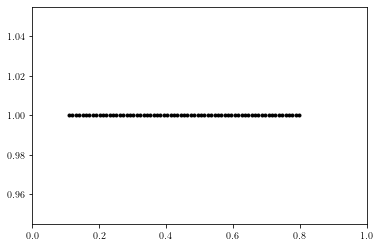

In [27]:
md_g, md_mean, md_sig, md_cov = new.MD_set(sigmas)

#check the size of the theory errors for comparison to the nugget
#print(sigmas**2.0, np.shape(sigmas))

#try to add small variance to cov to make it less singular
md_cov = md_cov #+ 0.0005*np.eye(len(md_cov))

#thin the prediction set to every 10 entries to try ref dist
md_g = md_g[::15]
md_mean = md_mean[::15]
md_sig = md_sig[::15]
md_cov = md_cov[::15,::15]

print(len(md_g), md_cov)

[[5.45928686e-05 1.76532132e-04 2.10734540e-04 1.70985689e-04
  7.95543237e-05]
 [1.76532132e-04 5.95190210e-04 7.41886619e-04 6.32070407e-04
  3.12684502e-04]
 [2.10734540e-04 7.41886619e-04 9.67151094e-04 8.64673681e-04
  4.53642414e-04]
 [1.70985689e-04 6.32070407e-04 8.64673681e-04 8.12553438e-04
  4.54121553e-04]
 [7.95543237e-05 3.12684502e-04 4.53642414e-04 4.54121553e-04
  2.81426775e-04]]
[[5.45928686e-05 1.76532132e-04 2.10734540e-04 1.70985689e-04
  7.95543237e-05]
 [1.76532132e-04 5.95190210e-04 7.41886619e-04 6.32070407e-04
  3.12684502e-04]
 [2.10734540e-04 7.41886619e-04 9.67151094e-04 8.64673681e-04
  4.53642414e-04]
 [1.70985689e-04 6.32070407e-04 8.64673681e-04 8.12553438e-04
  4.54121553e-04]
 [7.95543237e-05 3.12684502e-04 4.53642414e-04 4.54121553e-04
  2.81426775e-04]]
Squared Mahalanobis array: [ 8.89621295  2.40824409  6.57954786  7.80485526  6.74860487  5.11358642
  3.44981935 19.60766926  6.58221671  4.46490555 14.79588951  9.91556608
  5.13061725  3.32616117 

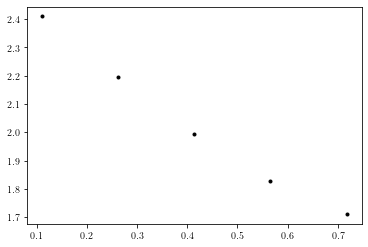

In [53]:
#compute cholesky 
chol = cholesky(md_cov)
matrix = chol @ chol.conj().T
print(matrix)
print(md_cov)

#generate MDs of the reference distribution
dist = ref_dist(md_mean, md_cov, random_state=1)
n_curves = 500
y = sample_ref(dist, n_curves)
md = np.ones([n_curves])
for i in range(n_curves):
    md[i] = mahalanobis(y[:,i].T, md_mean, inv=None, chol=chol)
    
#square the reference distribution MD
md2 = md**2.0 

#now calculate our specific value of the MD
model = Models()
fval = model.true_model(md_g)
md_gp = mahalanobis(fval.T, md_mean, inv=None, chol=chol)
md_gp2 = md_gp**2.0

#print out the values of each 
print('Squared Mahalanobis array:', md**2.0)
print('Squared MD for our GP:', md_gp**2.0)
print('Min of array: {}; max of array: {}'.format(min(md**2.0), max(md**2.0)))

plt.plot(md_g, y[:,i].T, 'k.')

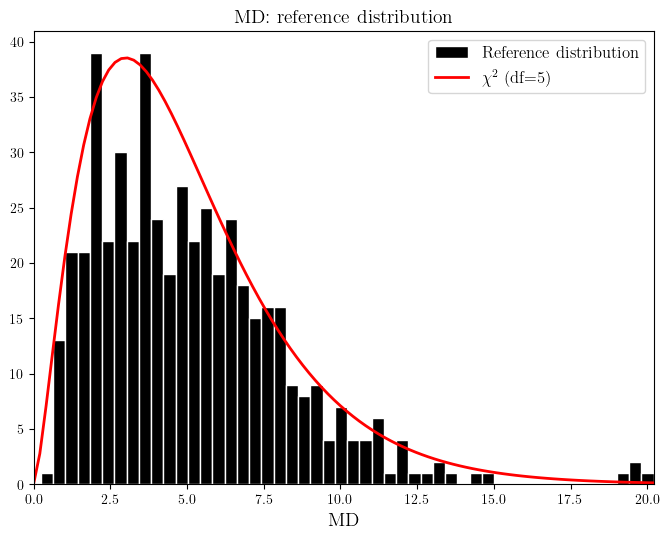

In [57]:
#plot the reference distribution histogram
fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.set_xlabel('MD', fontsize=14)
ax.set_title('MD: reference distribution', fontsize=14)
ax.set_xlim(0.0, max(md2))
histogram_data = ax.hist(md2, bins=50, histtype='bar', facecolor='black', ec='white', label='Reference distribution')
ax.plot(md_gp2, 0.0, 'r', marker='o', markersize=10)

#plot the chi-squared distribution over this histogram
ax.plot(np.linspace(0.0,max(md2),100), 250*stats.chi2.pdf(np.linspace(0.0,max(md2),100), df=5), 'r', linewidth=2, label=r'$\chi^{2}$ (df=5)')
ax.legend(loc='upper right', fontsize=12)
plt.show()